In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv("../dataset/Loan_Default.csv")
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
n_unique_values = 10
all_columns = df.columns.to_list()
categorical_columns = []

for i, column in enumerate(all_columns):
    temp = df.loc[:, column].unique()
    if len(temp) < n_unique_values:
        print (f"{i+1}. {column} has {len(temp)} unique values, which are {temp}")
        categorical_columns.append(column)
del temp

2. year has 1 unique values, which are [2019]
3. loan_limit has 3 unique values, which are ['cf' nan 'ncf']
4. Gender has 4 unique values, which are ['Sex Not Available' 'Male' 'Joint' 'Female']
5. approv_in_adv has 3 unique values, which are ['nopre' 'pre' nan]
6. loan_type has 3 unique values, which are ['type1' 'type2' 'type3']
7. loan_purpose has 5 unique values, which are ['p1' 'p4' 'p3' 'p2' nan]
8. Credit_Worthiness has 2 unique values, which are ['l1' 'l2']
9. open_credit has 2 unique values, which are ['nopc' 'opc']
10. business_or_commercial has 2 unique values, which are ['nob/c' 'b/c']
16. Neg_ammortization has 3 unique values, which are ['not_neg' 'neg_amm' nan]
17. interest_only has 2 unique values, which are ['not_int' 'int_only']
18. lump_sum_payment has 2 unique values, which are ['not_lpsm' 'lpsm']
20. construction_type has 2 unique values, which are ['sb' 'mh']
21. occupancy_type has 3 unique values, which are ['pr' 'sr' 'ir']
22. Secured_by has 2 unique values, whic

In [5]:
df['Gender'] = df['Gender'].replace("Sex Not Available", np.nan)

In [6]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns

['loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'LTV',
 'dtir1']

In [7]:
def get_missing_percent(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_missing_percent(df)

loan_limit : 3344 (2.249%)
Gender : 37659 (25.331%)
approv_in_adv : 908 (0.611%)
loan_purpose : 134 (0.09%)
rate_of_interest : 36439 (24.51%)
Interest_rate_spread : 36639 (24.645%)
Upfront_charges : 39642 (26.664%)
term : 41 (0.028%)
Neg_ammortization : 121 (0.081%)
property_value : 15098 (10.155%)
income : 9150 (6.155%)
age : 200 (0.135%)
submission_of_application : 200 (0.135%)
LTV : 15098 (10.155%)
dtir1 : 24121 (16.225%)


In [8]:
property_value_LTV_missing_correl = 0
interest_upfront_missing_correl = 0
for ind in df.index:
    if pd.isna(df['property_value'][ind]) and pd.isna(df['LTV'][ind]):
        property_value_LTV_missing_correl += 1
    if pd.isna(df['rate_of_interest'][ind]) and pd.isna(df['Interest_rate_spread'][ind]) and pd.isna(df['Upfront_charges'][ind]):
        interest_upfront_missing_correl += 1
print(property_value_LTV_missing_correl)
print(interest_upfront_missing_correl)
    

15098
36439


In [9]:
gender_interest_upfront_missing_correl = 0
for ind in df.index:
    if pd.isna(df['rate_of_interest'][ind]) and pd.isna(df['Interest_rate_spread'][ind]) and pd.isna(df['Upfront_charges'][ind]) and pd.isna(df['Gender'][ind]):
        gender_interest_upfront_missing_correl += 1
print(gender_interest_upfront_missing_correl)

10567


In [10]:
df['Gender'].unique()

array([nan, 'Male', 'Joint', 'Female'], dtype=object)

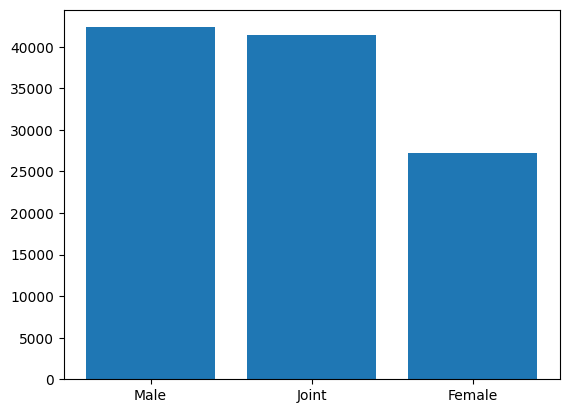

In [11]:
def gender_graph(df):
    df_copy = df['Gender'].copy()
    gender_freq = df_copy.value_counts()
    plt.bar(gender_freq.index, gender_freq.values)
    plt.show()
gender_graph(df)

In [12]:
df['Gender']

0            NaN
1           Male
2           Male
3           Male
4          Joint
           ...  
148665       NaN
148666      Male
148667      Male
148668    Female
148669    Female
Name: Gender, Length: 148670, dtype: object

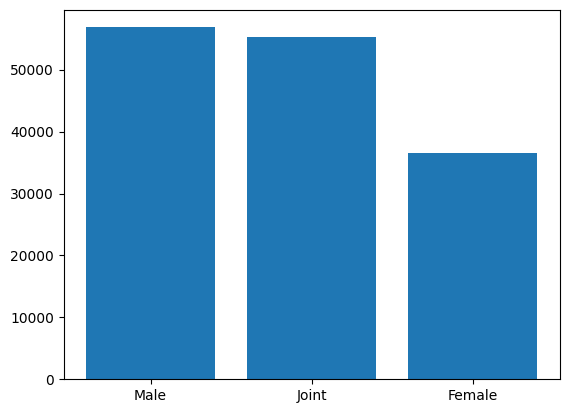

0           Male
1           Male
2           Male
3           Male
4          Joint
           ...  
148665      Male
148666      Male
148667      Male
148668    Female
148669    Female
Name: Gender, Length: 148670, dtype: object

In [13]:
df['Gender'].fillna(method="bfill", inplace=True)
gender_graph(df)
df['Gender']

In [14]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns


['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'LTV',
 'dtir1']

In [15]:
cat_missing_cols = [col for col in missing_columns if df[col].dtype == 'object']
cat_missing_cols


['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'Neg_ammortization',
 'age',
 'submission_of_application']

In [16]:
for col in cat_missing_cols:
    df[col].fillna(method="ffill", inplace=True)
    df[col].fillna(method="bfill", inplace=True)
    print(df[col].isna().sum())

0
0
0
0
0
0


In [17]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
for col in missing_columns:
    print(df[col].dtype)

float64
float64
float64
float64
float64
float64
float64
float64


In [19]:
knn = KNNImputer(n_neighbors = 3)
df_temp = df[missing_columns]
knn.fit(df_temp)
X = knn.transform(df_temp)
df_temp = pd.DataFrame(X, columns = missing_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 148670 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              148670 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148670 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [20]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rate_of_interest      148670 non-null  float64
 1   Interest_rate_spread  148670 non-null  float64
 2   Upfront_charges       148670 non-null  float64
 3   term                  148670 non-null  float64
 4   property_value        148670 non-null  float64
 5   income                148670 non-null  float64
 6   LTV                   148670 non-null  float64
 7   dtir1                 148670 non-null  float64
dtypes: float64(8)
memory usage: 9.1 MB


In [21]:
for col in missing_columns:
    df[col] = df_temp[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 148670 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              148670 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148670 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           148670 non-null  float64
 12  Interest_rate_spread       148670 non-null  float64
 13  Upfront_charges            14

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, _, _ = train_test_split(X, )